## Plot surface temperature differences between model and observations


Import preamble

In [6]:
import warnings
warnings.filterwarnings('ignore')

import coast
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

### Process Profiles

#### Define data paths
Set model paths.

In [20]:
path = "/gws/pw/j07/workshop/users/train006/AMM7_SSB_sample/"
model_path = path +  "amm7_1d_20070101_20070131_grid_T.nc"
jmmp_path = "/gws/nopw/j04/jmmp/"
domcfg_path = path + "amm7_SSB_mesh_mask.nc"

Set coast config paths. COAST uses configuration files to map model variables to common variable names.

In [22]:
cfg_path = "/home/users/train006/CLASS_workshop/Analysis/AMM/COAST_CFG/"
en4_json = cfg_path + "example_en4_profiles.json"
nemo_json = cfg_path + "example_nemo_grid_t.json"

Set observation path.

In [27]:
en4_path="/gws/pw/j07/workshop/users/train006/EN4/"
fn_prof = en4_path + "AMM15_processed_200701.nc"

#### COAST data import
COAST uses gridded objects to combine grid and data information.

In [23]:
nemo = coast.Gridded(model_path, domcfg_path, config=nemo_json)

We can interrogate this nemo Gridded object with the .dataset method. The Gridded data is served as an xarray dataset.

In [24]:
nemo.dataset

<xarray.Dataset>
Dimensions:               (z_dim: 51, axis_nbounds: 2, t_dim: 31, y_dim: 375,
                           x_dim: 297)
Coordinates:
  * time                  (t_dim) datetime64[ns] 2007-01-01T12:00:00 ... 2007...
    longitude             (y_dim, x_dim) float32 ...
    latitude              (y_dim, x_dim) float32 ...
    depth_0               (z_dim, y_dim, x_dim) float64 0.5 0.5 ... 50.5 50.5
Dimensions without coordinates: z_dim, axis_nbounds, t_dim, y_dim, x_dim
Data variables: (12/13)
    deptht_bounds         (z_dim, axis_nbounds) float32 dask.array<chunksize=(51, 2), meta=np.ndarray>
    e3t                   (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(2, 51, 375, 297), meta=np.ndarray>
    time_centered         (t_dim) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    time_centered_bounds  (t_dim, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_counter_bounds   (t_dim, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    salinity              (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(2, 51, 375, 297), meta=np.ndarray>
    ...                    ...
    bathymetry            (y_dim, x_dim) float64 2.984e+03 4.82e+03 ... 10.0
    e1                    (y_dim, x_dim) float64 ...
    e2                    (y_dim, x_dim) float64 ...
    e3_0                  (z_dim, y_dim, x_dim) float64 ...
    mask                  (z_dim, y_dim, x_dim) int8 ...
    bottom_level          (y_dim, x_dim) int16 ...
Attributes:
    name:         amm7_1d_20070101_20070131
    description:  tracer variables
    title:        tracer variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2017-Jan-03 15:21:26 GMT
    history:      Mon Feb  5 16:17:14 2024: ncks -v votemper,vosaline,e3t amm...
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...

Mask land and rename depth.

In [25]:
nemo.dataset["landmask"] = nemo.dataset.bottom_level == 0
nemo.dataset = nemo.dataset.rename({"depth_0": "depth"})

Use COAST to access en4 profiles using the coast profile object.

In [28]:
en4_profiles = coast.Profile(config=en4_json)
en4_profiles.dataset = xr.open_dataset(fn_prof, chunks={'id_dim':10000})

/home/users/train006/CLASS_workshop/Analysis/AMM/COAST_CFG/example_en4_profiles.json


Remove interpolation non-compliant variables.

In [29]:
var_list = (['qc_potential_temperature', 'qc_practical_salinity',
             'qc_depth', 'qc_time', 'qc_flags_profiles', 'qc_flags_levels'])
en4_profiles.dataset = en4_profiles.dataset.drop_vars(var_list)

Initialise COAST object.

In [30]:
analysis = coast.ProfileAnalysis()

#### Interpolate observations and model output to commom grid
#### Interpolate model to horizontal positions of observations
Interpolate model to horizontal positions of observations. Nearest neighbour interpolation of Gridded model object to observations
data that above a distance threshold from observations is discarded.

Nearest neighbour interpolation to profile positions.

In [31]:
nemo_profiles = en4_profiles.obs_operator(nemo) 

Drop data where interpolation distance is greater than "too_far".

In [32]:
too_far = 7
keep_indices = nemo_profiles.dataset.interp_dist <= too_far
nemo_profiles = nemo_profiles.isel(id_dim=keep_indices)
en4_profiles = en4_profiles.isel(id_dim=keep_indices)

#### Interpolate to regular depth
Interpolate model and observations to common vertical grid.

Set target depth levels.

In [33]:
ref_depth = np.concatenate((np.arange(1, 100, 10), np.arange(100, 1000, 5)))

Interpolate model profiles onto observation depths

In [34]:
nemo_profiles_obs_grid = analysis.interpolate_vertical(nemo_profiles, en4_profiles, interp_method="linear")

Interpolate model profiles to reference depths.

In [35]:
nemo_profiles_ref_grid = analysis.interpolate_vertical(nemo_profiles_obs_grid,ref_depth)

Interpolate obs. profiles to reference depths.

In [36]:
en4_profiles_ref_grid = analysis.interpolate_vertical(en4_profiles, ref_depth)

### Find difference difference between model and observations at the surface

Obs. and model average over the top 10 meters.

In [37]:
lower_bound = 10
nemo_profiles_surface = analysis.depth_means(nemo_profiles_ref_grid, [0, lower_bound])
en4_profiles_surface   = analysis.depth_means(en4_profiles_ref_grid, [0, lower_bound])

Get difference between model and observations at common positions.

In [38]:
surface_errors = analysis.difference(en4_profiles_surface, nemo_profiles_surface)

#### Plot differences between model and observations

Alias variables

In [40]:
c = surface_errors.dataset.diff_temperature
longitude = surface_errors.dataset.longitude.values
latitude = surface_errors.dataset.latitude.values

Plot (obs. - model) upper 10m averaged temperatures

In [41]:
coast.plot_util.geo_scatter(longitude, latitude, c=c, s=5,
                      scatter_kwargs=dict(vmin=-1.5, vmax=1.5, cmap=plt.cm.RdBu))

AttributeError: 'tuple' object has no attribute 'tb_frame'

### Compare Depth Profiles

In [105]:
profile_errors = analysis.difference(en4_profiles_ref_grid, nemo_profiles_ref_grid)
profile_errors.dataset = profile_errors.dataset.reset_coords("depth")
print (profile_errors.dataset)

<xarray.Dataset>
Dimensions:                  (id_dim: 440, z_dim: 190)
Coordinates:
    latitude                 (id_dim) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude                (id_dim) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time                     (id_dim) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: id_dim, z_dim
Data variables:
    depth                    (id_dim, z_dim) int64 1 11 21 31 ... 985 990 995
    diff_temperature         (id_dim, z_dim) float64 nan 0.002895 ... 0.6084
    abs_diff_temperature     (id_dim, z_dim) float64 nan 0.002895 ... 0.6084
    square_diff_temperature  (id_dim, z_dim) float64 nan 8.384e-06 ... 0.3702


In [86]:
mean_profile_errors = profile_errors.dataset.mean("id_dim")

In [119]:
quant = profile_errors.dataset.quantile([0.1,0.9], "id_dim")
lower_quant = quant.sel(quantile=0.1)
upper_quant = quant.sel(quantile=0.9)

Text(0, 0.5, 'Depth (m)')

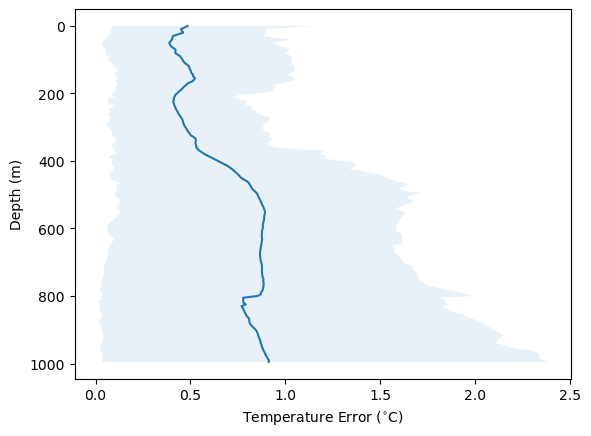

In [120]:
plt.plot(mean_profile_errors.abs_diff_temperature, mean_profile_errors.depth)
plt.fill_betweenx(mean_profile_errors.depth, lower_quant.abs_diff_temperature, upper_quant.abs_diff_temperature, alpha=0.1)
plt.gca().invert_yaxis()
plt.gca().set_xlabel(r'Temperature Error ($^{\circ}$C)')
plt.gca().set_ylabel('Depth (m)')